In [1]:
import os
import random
import math
import h5py
import concurrent.futures
import matplotlib.pyplot as plt
font = {'size'   : 5}
plt.rc('font', **font)

import numpy as np
import pandas as pd
import pandas.api.types
from tqdm import tqdm
from glob import glob
from PIL import Image
import cv2
from io import BytesIO

import torch
from torch import nn
import torch.nn.functional as F
import lightning as L

import albumentations as albu
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold, StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler


from libauc.losses import pAUCLoss
from libauc.optimizers import SOPAs
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score

import timm
import wandb

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
c:\Users\hoang\.conda\envs\bird\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lhkaay (lhklevi). Use `wandb login --relogin` to force relogin


True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print('Using device:', device)

Using device: cuda


In [13]:
default_config= {
 'VERSION': 'v3.3.1',
 'DESCRIPTION': 'XP light',
 'DATA_PATH': 'isic-2024-challenge',
 
 #-------Global-------#
 'IMAGE_SIZE': 224,
 'SEED': 24,
 #################################################
 
 #-------Image Augmentation-------#

 #################################################

 #-------Training hyperparameter-------#
 'BACKBONE': "tf_efficientnet_b3.in1k", # [ "tf_efficientnet_b3.in1k", "eca_nfnet_l0" 256,"tf_efficientnet_b0.in1k" 256; "tf_efficientnetv2_s.in21k" 300;  "seresnext26t_32x4d.bt_in1k" 224; "tf_efficientnet_b3.ns_jft_in1k" 300; "resnet34.a1_in1k" 224; "efficientnet_b3.ra2_in1k" 288; "resnet50.a1_in1k" 224; "eca_nfnet_l0.ra2_in1k" 224]
 'EPOCHS': 10,
 'FOLD': 5,
 'BACTHSIZE': 64,
 'LOSS': 'BCE With Logit'
 #################################################
}

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(default_config['SEED'])

In [6]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

# 1. Dataset

In [7]:
df_data = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
hdf5_file = h5py.File(f"{default_config['DATA_PATH']}/train-image.hdf5", mode="r")

sgkf = StratifiedGroupKFold(n_splits=default_config["FOLD"])
df_data['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(sgkf.split(df_data, df_data.target, df_data.patient_id)):
    df_data.loc[val_idx, 'fold'] = fold

df_data.groupby(['fold', 'target']).size()

C:\Users\hoang\AppData\Local\Temp\ipykernel_15236\1383095011.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")


fold  target
0     0         80134
      1            77
1     0         80133
      1            83
2     0         80133
      1            78
3     0         80133
      1            78
4     0         80133
      1            77
dtype: int64

In [8]:
df_data.groupby(['tbp_tile_type','target']).size()

tbp_tile_type  target
3D: XP         0         285706
               1            197
3D: white      0         114960
               1            196
dtype: int64

In [9]:
df_data[df_data['tbp_tile_type']=='3D: XP']


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,fold
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,4
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,1
6,ISIC_0051648,0,IP_0218255,65.0,male,upper extremity,3.74,TBP tile: close-up,3D: XP,14.319188,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.918133,0
7,ISIC_0051665,0,IP_7734648,50.0,male,posterior torso,4.31,TBP tile: close-up,3D: XP,20.102610,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.972390,1
9,ISIC_0051758,0,IP_2180091,60.0,female,upper extremity,3.97,TBP tile: close-up,3D: XP,16.251490,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999690,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401052,ISIC_9999883,0,IP_5024708,85.0,male,anterior torso,7.58,TBP tile: close-up,3D: XP,19.075495,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,1
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,1
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,1
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,1


In [10]:
df_positive = df_data[df_data["target"] == 1].reset_index(drop=True)
df_negative = df_data[df_data["target"] == 0].sample(frac=0.02, random_state=default_config['SEED'])

df_data = pd.concat([df_positive, df_negative]).reset_index(drop=True)  # positive:negative = 1:20

df_data = df_data[df_data['tbp_tile_type']=='3D: XP'].reset_index()

df_data['age_approx'] = df_data['age_approx'].fillna(df_data['age_approx'].mean())

df_data.groupby(['fold','target']).size()

fold  target
0     0         1216
      1           38
1     0         1094
      1           36
2     0         1133
      1           38
3     0         1030
      1           41
4     0         1195
      1           44
dtype: int64

In [11]:
class ISICDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5_file, df_data, mode='test'):
        self.df_data = df_data

        self.df_positive = df_data[df_data["target"] == 1].reset_index()
        self.df_negative = df_data[df_data["target"] == 0].reset_index()
        self.mode = mode

        if mode == 'train':
            ref_data = [{"isic_id":isic_id, "target":target} for isic_id, target in zip(df_data['isic_id'].tolist(), df_data['target'].tolist())]
            random.shuffle(ref_data)
            
            self.transform = albu.Compose([
                albu.Transpose(p=0.5),
                albu.VerticalFlip(p=0.5),
                albu.HorizontalFlip(p=0.5),
                albu.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.75),
                albu.OneOf([
                    albu.MotionBlur(blur_limit=3),
                    albu.MedianBlur(blur_limit=3),
                    albu.GaussianBlur(blur_limit=3),
                    albu.GaussNoise(var_limit=(3.0, 10.0)),
                ], p=0.7),
                albu.OneOf([
                    albu.OpticalDistortion(distort_limit=1.0),
                    albu.GridDistortion(num_steps=5, distort_limit=1.),
                    albu.ElasticTransform(alpha=3),
                ], p=0.7),
                albu.CLAHE(clip_limit=4.0, p=0.7),
                albu.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
                albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),

                albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
                albu.MixUp(p=0, reference_data=ref_data, read_fn=self.read_fn),

                albu.CoarseDropout(max_height=int(default_config['IMAGE_SIZE'] * 0.0375), max_width=int(default_config['IMAGE_SIZE'] * 0.0375), p=0.7),
                
                albu.Normalize(
                        mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225], 
                        max_pixel_value=255.0, 
                        p=1.0
                    ),
                ToTensorV2(p=1.0)])
        else:
            self.transform = albu.Compose([
                albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
                albu.Normalize(
                        mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225], 
                        max_pixel_value=255.0, 
                        p=1.0
                    ),
                ToTensorV2(p=1.0)])
        
        self.fp_hdf = hdf5_file
    
    def __len__(self):
        return len(self.df_data)
    
    def read_fn(self, item):
        transform = albu.Compose([albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE'], p=1)], p=1)
        image = transform(image=np.array(Image.open(BytesIO(self.fp_hdf[item['isic_id']][()]))))['image']
        onehot_target = np.zeros(2, dtype=int)
        onehot_target[item['target']] = 1

        return {
            "image": image,
            "global_label": onehot_target
        }
    
    def __getitem__(self, index):
        if random.random() >=0.5:
            df = self.df_positive
        else:
            df = self.df_negative
        
        index = index % df.shape[0]
        sample_row = df.iloc[index]
        
        image = np.array(Image.open(BytesIO(self.fp_hdf[sample_row['isic_id']][()])))

        if self.mode=='train':
            onehot_target = np.zeros(2, dtype=int)
            onehot_target[sample_row['target']] = 1
            transformed = self.transform(image=image, global_label=onehot_target)
            image = transformed['image']
            y = np.argmax(transformed['global_label'])
        else:
            image = self.transform(image=image)['image']
            y = sample_row['target']
        
        return image, y

In [12]:
dataset = ISICDataset(hdf5_file=hdf5_file, df_data=df_data, mode='valid')
dataset[2151][1]

1

## 1.1 Display one batch in Dataset

C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


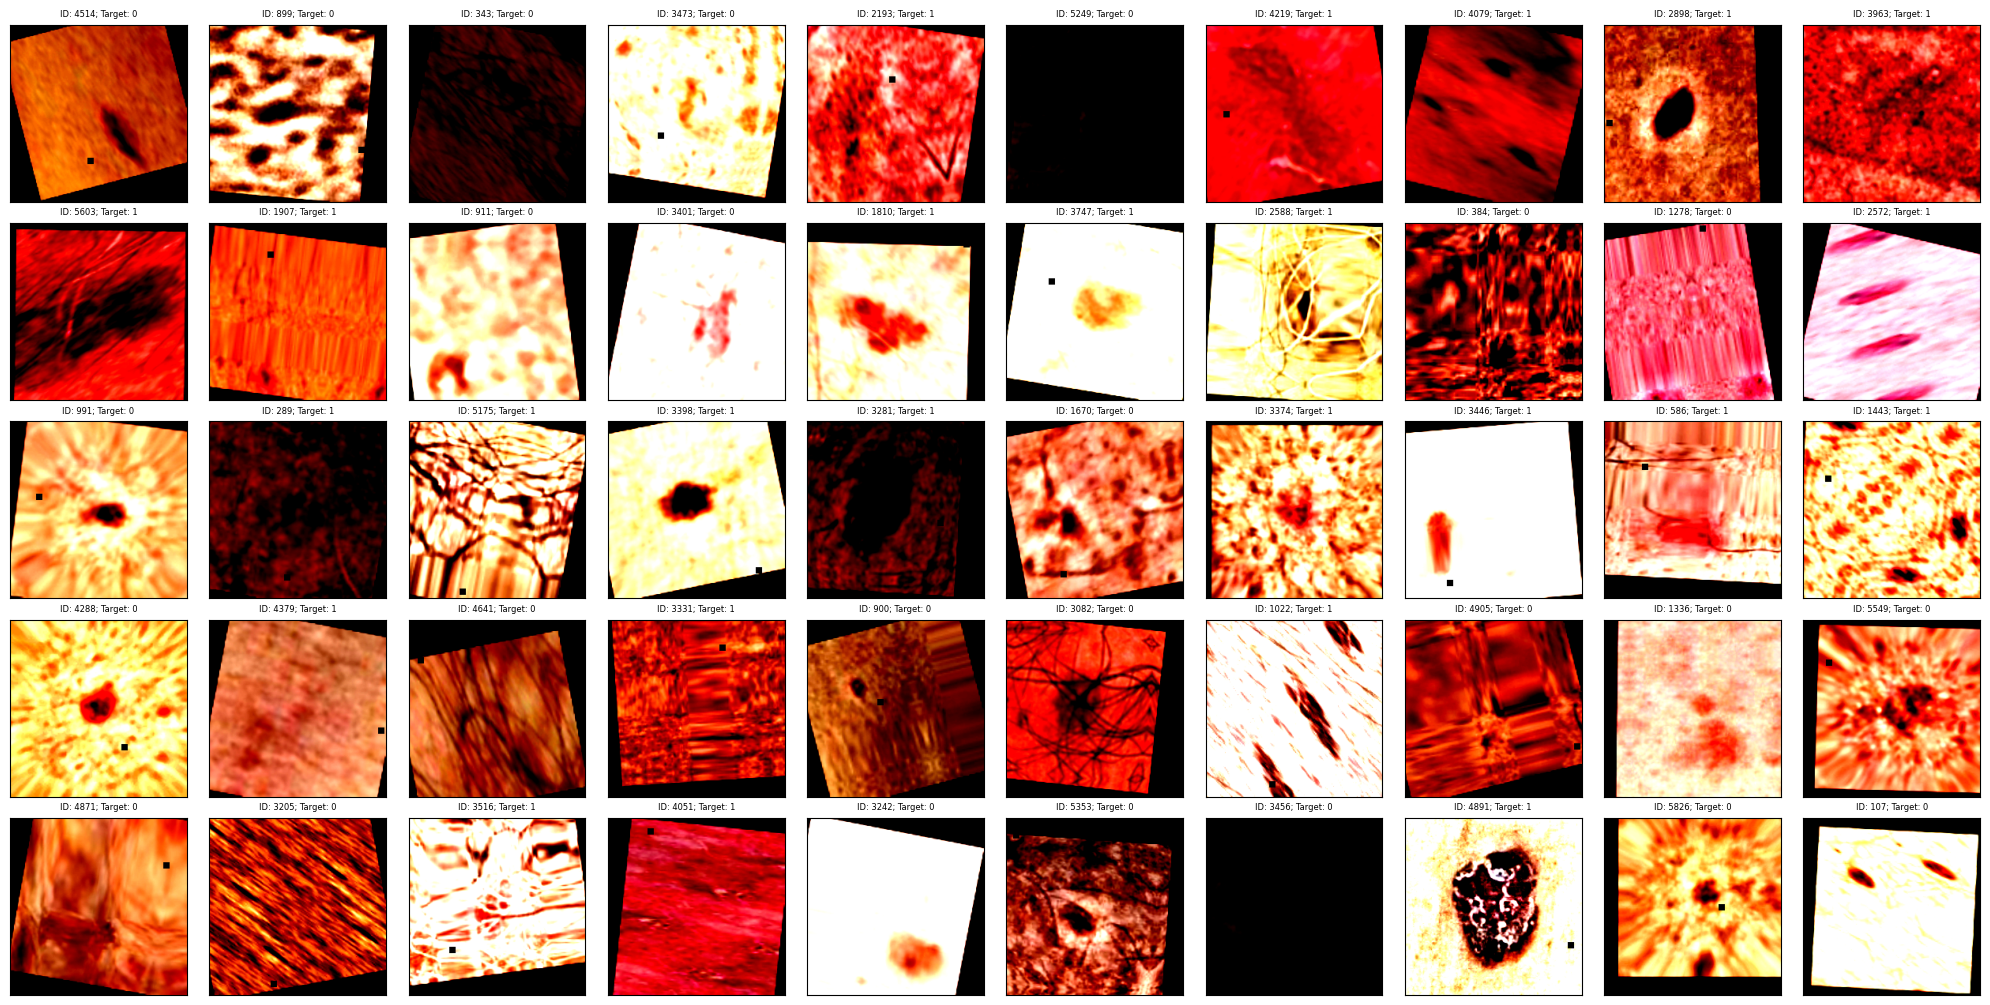

In [13]:
def display_batch(malignant_only=False):
    tmp_df = df_data
    if malignant_only:
        tmp_df = df_data[df_data['target']==1]
    dataset = ISICDataset(hdf5_file=hdf5_file, df_data=tmp_df, mode='train')
    fig = plt.figure(figsize=(20,10))
    
    img_index = np.random.randint(0, len(dataset)-1, 5*10)
    
    for i in range(len(img_index)):
        img, labels = dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy() 
        
        ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(np.transpose(img, (1,2,0)))
        lbl = labels.item()
        ax.set_title(f'ID: {img_index[i]}; Target: {lbl}')

    plt.tight_layout()
    plt.show()


display_batch(malignant_only=False)

## 2. Model

In [7]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
    
class ISICModel(nn.Module):
    def __init__(self, num_classes):
        super(ISICModel, self).__init__()

        self.backbone = timm.create_model(default_config['BACKBONE'], pretrained=True, num_classes=num_classes)

        if ("efficient" in default_config['BACKBONE']) :
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        elif ("resnet34" in default_config['BACKBONE']):
            in_features = 512
            self.backbone.global_pool = nn.Identity()
            self.backbone.fc = nn.Identity()
        else:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head = nn.Identity()

        self.globalpooling = GeM()
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, ximage):
        x = self.backbone(ximage)
        if ("swin" in default_config['BACKBONE']):
            x = x.transpose(1,3).contiguous()
        x = self.globalpooling(x).flatten(1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [15]:
# model = ISICModel(num_classes=1).to(device)
# inputs = torch.randn(64, 3, 224, 224).to(device)

# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     outputs = model(inputs)

# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [16]:
if not os.path.exists(f"model/{default_config['VERSION']}"):
    os.makedirs(f"model/{default_config['VERSION']}")

# 3.Training loop

In [8]:
import gc
import warnings
from torch.cuda.amp import autocast, GradScaler
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [18]:
for f in range(default_config["FOLD"]):
    run = wandb.init(project="ISIC2024", name=f"Model_Fold{f}_{default_config['VERSION']}", entity="lhklevi", config=default_config)
    wandb.alert(title=f"Start Model_Fold {f} !!!", text=f"Start Model_Fold {f} !!! [{default_config['DESCRIPTION']}]")
    # main loop of f-fold
    print('=================================================================================================')
    print(f"============================== Running training for fold {f} ==============================")
    
    train_df = df_data[df_data['fold'] != f].copy().reset_index(drop=True)

    valid_df = df_data[df_data['fold'] == f].copy().reset_index(drop=True)
    
    train_dataset = ISICDataset(hdf5_file, train_df, mode='train')
    valid_dataset = ISICDataset(hdf5_file, valid_df, mode='valid')

    print(f'Train Samples: {len(train_df)}')
#     display_batch(train_dataset)

    print(f'Valid Samples: {len(valid_df)}')
#     display_batch(valid_dataset)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)

    model = ISICModel(num_classes=1).to(device)

    # criterion = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss()
    # loss_fn = pAUCLoss('1w', data_len=len(train_dataset), margin=0.6, gamma=0.1)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
    # optimizer = SOPAs(model.parameters(), mode='adam', lr=1e-4, weight_decay=1e-6)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00017, steps_per_epoch=len(train_dataloader), epochs=default_config["EPOCHS"], anneal_strategy='cos')
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr'])

    # Training loop
    for epoch in range(default_config["EPOCHS"]):
        scaler = GradScaler()
        model.train()
        for idx,batch in enumerate(train_dataloader):
            inputs, targets = batch

            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            optimizer.zero_grad(set_to_none=True)
            # Forward pass

            with autocast():
                outputs = model(inputs).squeeze()
                # Compute loss
                loss = criterion(outputs, targets)

            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            print(f'Step {idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}\r', end='', flush=True)
            wandb.log({"Learning Rate":  optimizer.param_groups[-1]['lr']}) #scheduler.get_last_lr()[0]

        model.eval()
        valid_step = []
        with torch.no_grad(), autocast():
            for idx, batch in enumerate(valid_dataloader):
                inputs, targets = batch
                inputs = inputs.to(device, dtype=torch.float)

                outputs = model(inputs).squeeze()
                valid_step.append({"logits": outputs, "targets": targets.to(torch.float)})

            output_val = torch.cat([x['logits'] for x in valid_step], dim=0).cpu().detach()
            target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()

            val_loss = criterion(output_val, target_val)

            sigmoid = nn.Sigmoid()
            gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=['target'])
            pred_df = pd.DataFrame(sigmoid(output_val).numpy().astype(np.float32), columns=['target'])
            
            gt_df['isic_id'] = [f'id_{i}' for i in range(len(gt_df))]
            pred_df['isic_id'] = [f'id_{i}' for i in range(len(pred_df))]
            val_roc_auc = score(gt_df, pred_df, row_id_column_name='isic_id')

        print(f"Epoch {epoch+1}/{default_config['EPOCHS']}, train_loss: {loss.item():.4f}, valid_loss: {val_loss:.4f}, valid_score: {val_roc_auc:.4f} lr: {scheduler.get_last_lr()}")
        wandb.log({"Training Loss": loss.item(),"Valid Loss": val_loss, "Valid Score": val_roc_auc})
        gc.collect()

    torch.save(model.state_dict(), f"model/{default_config['VERSION']}/Model_Fold{f}.pt")
    wandb.save(f"model/{default_config['VERSION']}/Model_Fold{f}.pt")

    wandb.alert(title=f"Done Fold {f} !!!", text=f"Done Fold {f} !!!")
    run.finish()

============================== Running training for fold 0 ==============================
Train Samples: 4611
Valid Samples: 1254


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.7821, valid_loss: 0.4625, valid_score: 0.0946 lr: [4.7939932793572394e-05]
Epoch 2/10, train_loss: 0.3679, valid_loss: 0.4397, valid_score: 0.1267 lr: [0.00012987703337380787]
Epoch 3/10, train_loss: 0.7754, valid_loss: 0.7522, valid_score: 0.1390 lr: [0.0001699983936367124]
Epoch 4/10, train_loss: 0.0322, valid_loss: 0.3517, valid_score: 0.1547 lr: [0.00016135420608089183]
Epoch 5/10, train_loss: 0.1197, valid_loss: 0.5626, valid_score: 0.1417 lr: [0.00013758719892903567]
Epoch 6/10, train_loss: 0.4265, valid_loss: 0.3412, valid_score: 0.1601 lr: [0.0001034047194307832]
Epoch 7/10, train_loss: 0.4494, valid_loss: 0.3150, valid_score: 0.1616 lr: [6.55770268713629e-05]
Epoch 8/10, train_loss: 0.8633, valid_loss: 0.3298, valid_score: 0.1561 lr: [3.15963596883721e-05]
Epoch 9/10, train_loss: 0.2698, valid_loss: 0.3333, valid_score: 0.1612 lr: [8.19300576293615e-06]
Epoch 10/10, train_loss: 0.0759, valid_loss: 0.3106, valid_score: 0.1635 lr: [2.2863632876291613e-0

Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
Training Loss,▇▄▇▁▂▄▅█▃▁
Valid Loss,▃▃█▂▅▁▁▁▁▁
Valid Score,▁▄▆▇▆██▇██
Learning Rate,0.0
Training Loss,0.07587
Valid Loss,0.31061
Valid Score,0.16349


============================== Running training for fold 1 ==============================
Train Samples: 4735
Valid Samples: 1130


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.4912, valid_loss: 0.5271, valid_score: 0.1122 lr: [4.79353120527282e-05]
Epoch 2/10, train_loss: 0.3903, valid_loss: 0.4918, valid_score: 0.0967 lr: [0.00012986786836592933]
Epoch 3/10, train_loss: 0.7070, valid_loss: 0.6326, valid_score: 0.0729 lr: [0.00016999843675845808]
Epoch 4/10, train_loss: 0.3872, valid_loss: 0.4922, valid_score: 0.1062 lr: [0.00016135730886844625]
Epoch 5/10, train_loss: 0.3849, valid_loss: 0.4206, valid_score: 0.1261 lr: [0.0001375927468372705]
Epoch 6/10, train_loss: 0.3905, valid_loss: 0.4076, valid_score: 0.1342 lr: [0.0001034116136284318]
Epoch 7/10, train_loss: 0.2996, valid_loss: 0.4016, valid_score: 0.1383 lr: [6.558390187802925e-05]
Epoch 8/10, train_loss: 0.2979, valid_loss: 0.4692, valid_score: 0.1347 lr: [3.160185382466948e-05]
Epoch 9/10, train_loss: 0.5344, valid_loss: 0.4603, valid_score: 0.1498 lr: [8.196030847789742e-06]
Epoch 10/10, train_loss: 0.2420, valid_loss: 0.4742, valid_score: 0.1452 lr: [2.2432415419300502e-

Learning Rate,▁▁▂▃▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
Training Loss,▅▃█▃▃▃▂▂▅▁
Valid Loss,▅▄█▄▂▁▁▃▃▃
Valid Score,▅▃▁▄▆▇▇▇██
Learning Rate,0.0
Training Loss,0.24198
Valid Loss,0.47424
Valid Score,0.14524


============================== Running training for fold 2 ==============================
Train Samples: 4694
Valid Samples: 1171


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.6151, valid_loss: 0.4396, valid_score: 0.1318 lr: [4.79353120527282e-05]
Epoch 2/10, train_loss: 0.7285, valid_loss: 0.4342, valid_score: 0.1205 lr: [0.00012986786836592933]
Epoch 3/10, train_loss: 0.3432, valid_loss: 0.3956, valid_score: 0.1317 lr: [0.00016999843675845808]
Epoch 4/10, train_loss: 0.8580, valid_loss: 0.3998, valid_score: 0.1481 lr: [0.00016135730886844625]
Epoch 5/10, train_loss: 0.2291, valid_loss: 0.6109, valid_score: 0.1104 lr: [0.0001375927468372705]
Epoch 6/10, train_loss: 0.4771, valid_loss: 0.3740, valid_score: 0.1491 lr: [0.0001034116136284318]
Epoch 7/10, train_loss: 0.4206, valid_loss: 0.4891, valid_score: 0.1332 lr: [6.558390187802925e-05]
Epoch 8/10, train_loss: 0.4231, valid_loss: 0.3795, valid_score: 0.1524 lr: [3.160185382466948e-05]
Epoch 9/10, train_loss: 0.3464, valid_loss: 0.4259, valid_score: 0.1409 lr: [8.196030847789742e-06]
Epoch 10/10, train_loss: 0.4619, valid_loss: 0.3931, valid_score: 0.1448 lr: [2.2432415419300502e-

Learning Rate,▁▁▂▃▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
Training Loss,▅▇▂█▁▄▃▃▂▄
Valid Loss,▃▃▂▂█▁▄▁▃▂
Valid Score,▅▃▅▇▁▇▅█▆▇
Learning Rate,0.0
Training Loss,0.46193
Valid Loss,0.39311
Valid Score,0.14482


============================== Running training for fold 3 ==============================
Train Samples: 4794
Valid Samples: 1071


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.5534, valid_loss: 0.5325, valid_score: 0.1059 lr: [4.79308152469359e-05]
Epoch 2/10, train_loss: 0.4532, valid_loss: 0.4628, valid_score: 0.1369 lr: [0.00012985894817211678]
Epoch 3/10, train_loss: 0.4901, valid_loss: 0.4737, valid_score: 0.1460 lr: [0.00016999847816686603]
Epoch 4/10, train_loss: 0.4668, valid_loss: 0.3949, valid_score: 0.1316 lr: [0.00016136032840885405]
Epoch 5/10, train_loss: 0.3609, valid_loss: 0.4369, valid_score: 0.1170 lr: [0.00013759814645266814]
Epoch 6/10, train_loss: 0.5126, valid_loss: 0.3692, valid_score: 0.1454 lr: [0.00010341832385876788]
Epoch 7/10, train_loss: 0.4098, valid_loss: 0.3907, valid_score: 0.1476 lr: [6.55905936798901e-05]
Epoch 8/10, train_loss: 0.5563, valid_loss: 0.3135, valid_score: 0.1620 lr: [3.1607201804627036e-05]
Epoch 9/10, train_loss: 0.3018, valid_loss: 0.3629, valid_score: 0.1576 lr: [8.198975772824683e-06]
Epoch 10/10, train_loss: 0.2219, valid_loss: 0.3790, valid_score: 0.1496 lr: [2.2018331339776458

Learning Rate,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
Training Loss,█▆▇▆▄▇▅█▃▁
Valid Loss,█▆▆▄▅▃▃▁▃▃
Valid Score,▁▅▆▄▂▆▆█▇▆
Learning Rate,0.0
Training Loss,0.22194
Valid Loss,0.37904
Valid Score,0.14959


============================== Running training for fold 4 ==============================
Train Samples: 4626
Valid Samples: 1239


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.5047, valid_loss: 0.5697, valid_score: 0.0915 lr: [4.7939932793572394e-05]
Epoch 2/10, train_loss: 0.5195, valid_loss: 0.6398, valid_score: 0.0787 lr: [0.00012987703337380787]
Epoch 3/10, train_loss: 0.4036, valid_loss: 0.3702, valid_score: 0.1544 lr: [0.0001699983936367124]
Epoch 4/10, train_loss: 0.4262, valid_loss: 0.4215, valid_score: 0.1442 lr: [0.00016135420608089183]
Epoch 5/10, train_loss: 0.3839, valid_loss: 0.4414, valid_score: 0.1355 lr: [0.00013758719892903567]
Epoch 6/10, train_loss: 0.4724, valid_loss: 0.3880, valid_score: 0.1429 lr: [0.0001034047194307832]
Epoch 7/10, train_loss: 0.2020, valid_loss: 0.3835, valid_score: 0.1515 lr: [6.55770268713629e-05]
Epoch 8/10, train_loss: 0.2743, valid_loss: 0.3151, valid_score: 0.1560 lr: [3.15963596883721e-05]
Epoch 9/10, train_loss: 0.3672, valid_loss: 0.3518, valid_score: 0.1515 lr: [8.19300576293615e-06]
Epoch 10/10, train_loss: 0.2525, valid_loss: 0.3584, valid_score: 0.1493 lr: [2.2863632876291613e-0

Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
Training Loss,██▅▆▅▇▁▃▅▂
Valid Loss,▆█▂▃▄▃▂▁▂▂
Valid Score,▂▁█▇▆▇███▇
Learning Rate,0.0
Training Loss,0.25247
Valid Loss,0.35845
Valid Score,0.14928


# Evaluation

In [9]:
class ISICTestDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5_file, isic_ids, transform):
        self.isic_ids = isic_ids

        self.transform = transform
        self.fp_hdf = hdf5_file
    
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        image = np.array(Image.open(BytesIO(self.fp_hdf[isic_id][()])))
        image = self.transform(image=image)['image']
        
        return image
    
test_transform = albu.Compose([
        albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
        albu.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(p=1.0)])

In [10]:
df_metadata = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
df_metadata['tbp_tile_type'].unique()

C:\Users\hoang\AppData\Local\Temp\ipykernel_7836\2815241862.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metadata = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")


array(['3D: white', '3D: XP'], dtype=object)

In [14]:
default_config['VERSION']

'v3.3.1'

In [15]:
df_metadata = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
hdf5_file = h5py.File(f"{default_config['DATA_PATH']}/train-image.hdf5", mode="r")
df_metadata['age_approx'] = df_metadata['age_approx'].fillna(df_metadata['age_approx'].mean())

sgkf = StratifiedGroupKFold(n_splits=default_config["FOLD"])
df_metadata['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(sgkf.split(df_metadata, df_metadata.target, df_metadata.patient_id)):
    df_metadata.loc[val_idx, 'fold'] = fold

df_metadata = df_metadata[df_metadata['tbp_tile_type']=='3D: XP'].reset_index()

model = ISICModel(1)
oof_predictions = np.zeros(len(df_metadata))

for f in range(default_config['FOLD']):
    model.load_state_dict(torch.load(f"model/{default_config['VERSION']}/Model_Fold{f}.pt"))
    model.to(device)
    model.eval()
    
    fold_df = df_metadata[df_metadata['fold'] == f].copy()
    test_dataset = ISICTestDataset(hdf5_file, fold_df['isic_id'].values, test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=default_config['BACTHSIZE'], shuffle=False)
    
    all_preds = []
    # models = [model]
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        for imgs in tqdm(test_loader):
            imgs = imgs.to("cuda")
            preds = sigmoid(model(imgs).detach().cpu()).numpy()
            all_preds.extend(preds)

    all_preds_df = pd.DataFrame({'pred':all_preds})
    all_preds = all_preds_df['pred'].rank(pct=True).to_numpy()
    
    oof_predictions[fold_df.index] = all_preds

oof_df = pd.DataFrame({
        'isic_id': df_metadata['isic_id'],
        'target': df_metadata['target'],
        'fold': df_metadata['fold'],
        'oof_prediction': oof_predictions
    })

oof_df.to_csv(f'train_oof_prediction_{default_config["VERSION"].replace(".","_")}.csv', index=False)

C:\Users\hoang\AppData\Local\Temp\ipykernel_7836\1736330829.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metadata = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)
INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
100%|██████████| 895/895 [02:12<00:00,  6.74it/s]


In [16]:
v330 = pd.read_csv('train_oof_prediction_v3_3_0.csv')
v331 = pd.read_csv('train_oof_prediction_v3_3_1.csv')
v33 = pd.concat([v330,v331]).reset_index(drop=True)
v33

,isic_id,target,fold,oof_prediction
0,ISIC_0015670,0,4,0.563104
1,ISIC_0015845,0,2,0.471437
2,ISIC_0024200,0,4,0.609540
3,ISIC_0035502,0,4,0.877753
4,ISIC_0051710,0,3,0.484654
...,...,...,...,...
401054,ISIC_9999883,0,1,0.761373
401055,ISIC_9999937,0,1,0.650935
401056,ISIC_9999960,0,1,0.125324
401057,ISIC_9999964,0,1,0.834370


In [17]:
v33.to_csv('train_oof_prediction_v3_3_ranked.csv', index=False)